In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('preprocessed_telecom_xdr_data.csv')

1. Aggregate the Metrics per Customer ID (MSISDN)

In [3]:
import pandas as pd

# Step 1: Aggregate the metrics per MSISDN (customer ID)
def aggregate_metrics(df):
    # Aggregate session frequency, session duration, total download (DL) and upload (UL) data
    aggregated_df = df.groupby('MSISDN/Number').agg({
        'Dur. (ms)': 'sum',  # Total session duration
        'Total DL (Bytes)': 'sum',  # Total download data
        'Total UL (Bytes)': 'sum',  # Total upload data
        'Bearer Id': 'count'  # Session frequency
    }).reset_index()
    
    # Add total traffic column (DL + UL)
    aggregated_df['Total Traffic (Bytes)'] = aggregated_df['Total DL (Bytes)'] + aggregated_df['Total UL (Bytes)']
    
    # Rename columns for better readability
    aggregated_df.rename(columns={
        'MSISDN/Number': 'Customer ID',
        'Bearer Id': 'Session Frequency',
        'Dur. (ms)': 'Total Duration (ms)',
        'Total DL (Bytes)': 'Total Download (Bytes)',
        'Total UL (Bytes)': 'Total Upload (Bytes)',
        'Total Traffic (Bytes)': 'Total Traffic (Bytes)'
    }, inplace=True)
    
    return aggregated_df

# Call the function and perform sorting
aggregated_data = aggregate_metrics(df)

# Extract top 10 customers for each metric
top_10_customers_duration = aggregated_data.nlargest(10, 'Total Duration (ms)')
top_10_customers_traffic = aggregated_data.nlargest(10, 'Total Traffic (Bytes)')
top_10_customers_frequency = aggregated_data.nlargest(10, 'Session Frequency')

# Format large numbers for display purposes
def format_large_numbers(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: f"{x:,.0f}")
    return df

# Columns to format
columns_to_format = ['Total Duration (ms)', 'Total Download (Bytes)', 'Total Upload (Bytes)', 'Total Traffic (Bytes)']

# Format top 10 results for cleaner display
top_10_customers_duration = format_large_numbers(top_10_customers_duration, ['Total Duration (ms)'])
top_10_customers_traffic = format_large_numbers(top_10_customers_traffic, ['Total Traffic (Bytes)'])
top_10_customers_frequency['Session Frequency'] = top_10_customers_frequency['Session Frequency'].apply(lambda x: f"{x:,.0f}")

# Display the top 10 customers in a cleaner format
print("Top 10 Customers by Total Duration (s):\n", top_10_customers_duration[['Customer ID', 'Total Duration (ms)']].to_string(index=False))
print("\nTop 10 Customers by Total Traffic (Bytes):\n", top_10_customers_traffic[['Customer ID', 'Total Traffic (Bytes)']].to_string(index=False))
print("\nTop 10 Customers by Session Frequency:\n", top_10_customers_frequency[['Customer ID', 'Session Frequency']].to_string(index=False))




Top 10 Customers by Total Duration (s):
  Customer ID Total Duration (ms)
3.362578e+10          18,553,754
3.361489e+10           8,995,388
3.376054e+10           8,385,380
3.366716e+10           8,078,981
3.362632e+10           7,688,487
3.366469e+10           6,288,730
3.366746e+10           5,649,882
3.360313e+10           5,090,838
3.376041e+10           5,066,911
3.366159e+10           4,976,479

Top 10 Customers by Total Traffic (Bytes):
  Customer ID Total Traffic (Bytes)
3.362578e+10                 7,320
3.361489e+10                 6,774
3.362632e+10                 6,607
3.366646e+10                 5,845
3.376054e+10                 5,310
3.362708e+10                 5,049
3.365802e+10                 4,883
3.366469e+10                 4,867
3.376041e+10                 4,861
3.366716e+10                 4,847

Top 10 Customers by Session Frequency:
  Customer ID Session Frequency
3.362578e+10                17
3.361489e+10                16
3.362632e+10                16
3

2. Normalize Each Engagement Metric and Run k-Means Clustering

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 2: Normalize engagement metrics
def normalize_metrics(aggregated_df):
    scaler = StandardScaler()
    metrics_to_normalize = ['Session Frequency', 'Total Duration (ms)', 'Total Traffic (Bytes)']
    normalized_df = pd.DataFrame(scaler.fit_transform(aggregated_df[metrics_to_normalize]), columns=metrics_to_normalize)
    return normalized_df

normalized_metrics = normalize_metrics(aggregated_data)

# Step 3: Apply k-means clustering
def apply_kmeans(normalized_df, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_df)
    return kmeans.labels_

aggregated_data['Engagement Cluster'] = apply_kmeans(normalized_metrics)

# Display the clustered data
aggregated_data.head(10)


,Customer ID,Total Duration (ms),Total Download (Bytes),Total Upload (Bytes),Session Frequency,Total Traffic (Bytes),Engagement Cluster
0,3.360100e+10,116720.0,455.940801,36.053108,1,491.993909,0
1,3.360100e+10,181230.0,120.755184,36.104459,1,156.859643,0
2,3.360100e+10,134969.0,556.659663,39.306820,1,595.966483,0
3,3.360101e+10,49878.0,401.993172,20.327526,1,422.320698,0
4,3.360101e+10,37104.0,1003.036989,79.623348,2,1082.660337,1
5,3.360101e+10,253983.0,555.207972,60.009249,2,615.217221,1
6,3.360101e+10,64180.0,381.330543,41.141959,1,422.472502,0
7,3.360101e+10,86399.0,294.085078,38.575279,1,332.660357,0
8,3.360101e+10,495702.0,896.560173,76.884397,2,973.444570,1
9,3.360102e+10,124854.0,685.372753,47.091008,1,732.463761,0


3. Compute Metrics for Each Cluster


In [5]:
# Step 4: Calculate metrics for each cluster
def calculate_cluster_metrics(df):
    cluster_metrics = df.groupby('Engagement Cluster').agg({
        'Session Frequency': ['min', 'max', 'mean', 'sum'],
        'Total Duration (ms)': ['min', 'max', 'mean', 'sum'],
        'Total Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
    })
    return cluster_metrics

cluster_metrics = calculate_cluster_metrics(aggregated_data)
cluster_metrics.head()


Session Frequency                      Total Duration (ms)  \
                                 min max      mean    sum                 min   
Engagement Cluster                                                              
0                                  1   2  1.013927  76444              7142.0   
1                                  1   4  2.155363  43603             18235.0   
2                                  1  17  4.107575  10195             66594.0   

                                                             \
                           max           mean           sum   
Engagement Cluster                                            
0                    1035261.0  106137.510982  8.002132e+09   
1                    1474663.0  218214.783243  4.414485e+09   
2                   18553754.0  690465.517728  1.713735e+09   

                   Total Traffic (Bytes)                            \
                                     min          max         mean   
Engagement Cluster                                                   
0                              33.249009   802.792098   439.617073   
1                             177.006936  2098.109935   960.922243   
2                             356.783538  7320.177425  1888.909361   

                                  
                             sum  
Engagement Cluster                
0                   3.314449e+07  
1                   1.943946e+07  
2                   4.688273e+06

4. Aggregate User Traffic Per Application and Find Top 10 Most Engaged Users

In [6]:
import pandas as pd

# Step 5: Aggregate traffic per application
applications = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)', 
                'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 
                'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
                'Google DL (Bytes)', 'Google UL (Bytes)', 
                'Email DL (Bytes)', 'Email UL (Bytes)', 
                'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 
                'Other DL (Bytes)', 'Other UL (Bytes)']

def aggregate_application_data(df, applications):
    application_traffic = df.groupby('MSISDN/Number')[applications].sum().reset_index()
    for app in applications:
        application_traffic[f'{app}_Total'] = application_traffic[app]  # No need to separate DL/UL if total is available
    return application_traffic

# Step 6: Aggregate and find the top 10 users for each application
def get_top_10_per_application(df, applications):
    top_10_per_app = {}
    for app in applications:
        top_10_users = df.nlargest(10, f'{app}_Total')  # Find top 10 users for the application
        top_10_per_app[app] = top_10_users  # Store in dictionary with app name as the key
    return top_10_per_app

# Aggregate the application data
application_traffic = aggregate_application_data(df, applications)

# Get the top 10 users for each application
top_10_per_app = get_top_10_per_application(application_traffic, applications)

# Display top 10 users for each application
for app, top_10_df in top_10_per_app.items():
    print(f"\nTop 10 users for {app}:\n")
    print(top_10_df[['MSISDN/Number', f'{app}_Total']].to_string(index=False))



Top 10 users for Social Media DL (Bytes):

 MSISDN/Number  Social Media DL (Bytes)_Total
  3.362632e+10                      27.998532
  3.361489e+10                      22.843403
  3.376054e+10                      21.897968
  3.362578e+10                      21.612543
  3.366159e+10                      20.316457
  3.366907e+10                      19.002898
  3.366716e+10                      18.299309
  3.365973e+10                      18.263313
  3.378632e+10                      17.833751
  3.366553e+10                      16.607685

Top 10 users for Social Media UL (Bytes):

 MSISDN/Number  Social Media UL (Bytes)_Total
  3.361489e+10                       0.480676
  3.362632e+10                       0.445898
  3.362578e+10                       0.445072
  3.365973e+10                       0.396464
  3.366716e+10                       0.388206
  3.366646e+10                       0.340253
  3.367588e+10                       0.333337
  3.366547e+10                       0

5. Plot Top 3 Most Used Applications

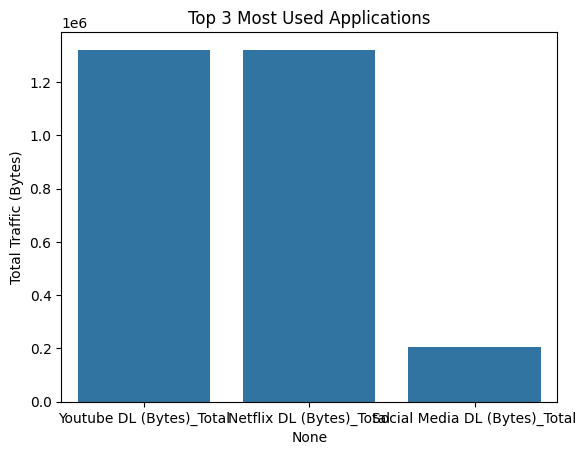

In [7]:
import seaborn as sns

# Step 7: Plot the top 3 most used applications
def plot_top_applications(df, apps):
    total_traffic_per_app = df[apps].sum()
    top_3_apps = total_traffic_per_app.nlargest(3)
    
    sns.barplot(x=top_3_apps.index, y=top_3_apps.values)
    plt.title("Top 3 Most Used Applications")
    plt.ylabel("Total Traffic (Bytes)")
    plt.show()

top_3_apps = ['Social Media DL (Bytes)_Total', 'Youtube DL (Bytes)_Total', 'Netflix DL (Bytes)_Total']
plot_top_applications(application_traffic, top_3_apps)


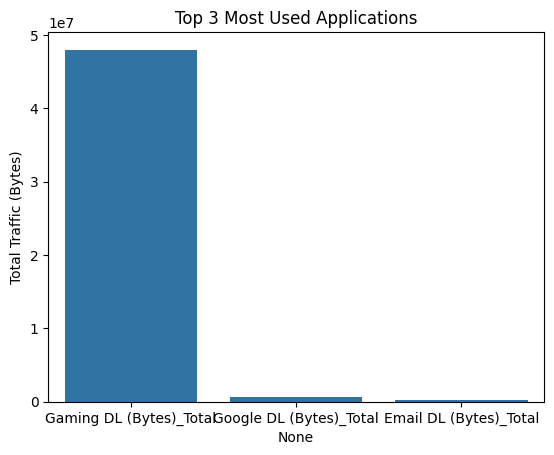

In [8]:
# Step 7: Plot the top 3 most used applications
def plot_top_applications(df, apps):
    total_traffic_per_app = df[apps].sum()
    top_3_apps = total_traffic_per_app.nlargest(3)
    
    sns.barplot(x=top_3_apps.index, y=top_3_apps.values)
    plt.title("Top 3 Most Used Applications")
    plt.ylabel("Total Traffic (Bytes)")
    plt.show()

top_3_apps = ['Google DL (Bytes)_Total', 'Email DL (Bytes)_Total', 'Gaming DL (Bytes)_Total']
plot_top_applications(application_traffic, top_3_apps)

6. Determine Optimal k Value Using Elbow Method

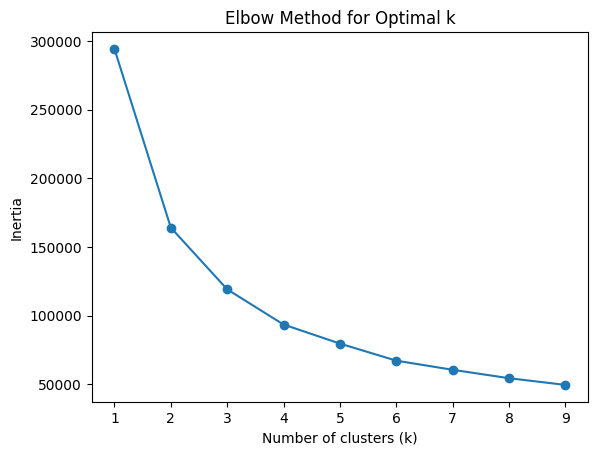

In [9]:
# Step 8: Determine the optimal value of k using the elbow method
def elbow_method(normalized_df):
    inertia = []
    k_range = range(1, 10)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(normalized_df)
        inertia.append(kmeans.inertia_)
    
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

elbow_method(normalized_metrics)


In [11]:
aggregated_data.to_csv('engagement_data.csv', index=False)